In [1]:
import json
import os
import warnings


def create_dir(path):
    dir_path = os.path.dirname(path)
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"{dir_path} : has been created successfully")
    else:
        print(f"{dir_path} : has already exist")


def jload(path, lines=True):
    if not os.path.exists(path):
        raise ValueError("path not exist")
    if lines is True:
        data = [json.loads(_) for _ in open(path, "r", encoding="utf-8") if _ != ""]
    else:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
    return data


def jdump(obj, path, mode="w", lines=True, indent=4):
    assert type(obj) is list or type(obj) is dict
    if mode != "w" and mode != "a":
        raise ValueError("error mode")
    if not os.path.exists(os.path.dirname(path)):
        create_dir(path)
    if type(obj) is dict:
        obj = [obj]

    if lines is True:
        with open(path, mode, encoding="utf-8") as f:
            for item in obj:
                f.write(json.dumps(item, ensure_ascii=False) + "\n")
    else:
        if mode == "w":
            with open(path, "w") as f:
                json.dump(obj, f, indent=indent, ensure_ascii=False)
        elif mode == "a":
            with open(path, "a+") as f:
                data = json.load(path)
                json.dump(data + obj, f, indent=indent, ensure_ascii=False)


def read_file(path):
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()
    return text


In [2]:
   
import random
random.seed(7)
import json
import pandas as pd
from pathlib import Path

def get_annotations(data_dir,index=-1):
    path= Path(data_dir)
    outs={}
    index_keys = []
    for p in path.glob("*.json"):
        data=jload(p,lines=False)
        out=[]
        for item in data:
            labels=[]
            ann=item['annotations'][0]
            results=ann['result']
            for r in results:
                v=r['value']
                labels.append([v['start'],v['end'],v['labels'][0]])
            item=item['data']
            item['label']=labels
            out.append(item)
        outs[str(p)]=out
        index_keys.append(str(p))
    if index<0:
        return outs
    else:
        key = index_keys[index]
        return {
            key:outs[key]
        }
def style_check(row):
    label=row['label']
    for l in label:
        if l[2] in ["Unnatural Phrase Flow","Unnatural Sentence Flow"]:
            return True
    return False

def style_ratio_check(row):
    tranlation_len=len(row['translation'])
    style_err_length=0
    label=row['label']
    for l in label:
        if l[2] in  ["Unnatural Phrase Flow","Unnatural Sentence Flow"]:
            style_err_length+=l[1]-l[0]
    return style_err_length/tranlation_len

In [3]:
data_by_ann = {}
for index in range(3):
    datass={}
    # for i in range(10):
    delta = (get_annotations(f"./enzh",index=index))
    datass = {**datass,**delta}
    data=[]
    print(datass.keys())
    for key in datass:
        data+=(datass[key])
    df=pd.DataFrame(data)
    df["style_err"]=df.apply(style_check,axis=1)
    df["style_err_ratio"]=df.apply(style_ratio_check,axis=1)
    data_by_ann[index] = df

dict_keys(['enzh/project-47-at-2024-09-13-07-09-855d54e5.json'])
dict_keys(['enzh/project-49-at-2024-09-13-07-10-7cdcc62b.json'])
dict_keys(['enzh/project-50-at-2024-09-13-07-10-2d149e10.json'])


<Figure size 640x480 with 0 Axes>

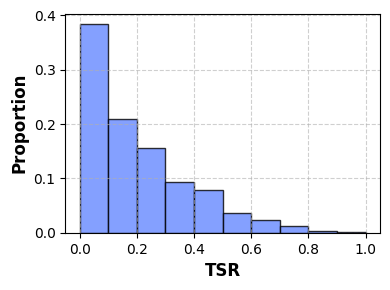

In [4]:
esrs = []
data_with_esrs = []
for i in range(500):
    cache = []
    for j in range(3):
        esr = data_by_ann[j].iloc[i]["style_err_ratio"]
        cache.append(esr)
    avg_esr = sum(cache)/len(cache)
    esrs.append(avg_esr)

    _data = {
        "text": data_by_ann[j].iloc[i]["text"],
        "translation": data_by_ann[j].iloc[i]["translation"],
        "avg_esr": avg_esr,
    }
    data_with_esrs.append(_data)


import matplotlib.pyplot as plt

# Sample data (replace 'esrs' with your actual data)
values = esrs

# Define the number of bins and bin edges
bin_width = 0.1
bins = [e * bin_width for e in range(int(1/bin_width) + 1)]  # e.g., [0, 0.1, 0.2, ..., 1.0]

# Create a histogram with frequency counts
counts, edges, patches = plt.hist(values, bins=bins, edgecolor='black', alpha=0.8, color='#4CAF50')

# Calculate relative frequency
total_values = len(values)
relative_frequencies = counts / total_values

# Clear the current plot to draw again with relative frequency
plt.clf()
plt.figure(figsize=(4, 3)) 

# Plot the histogram with relative frequencies
# To align bars with bin edges, use the following:
bar_width = bins[1] - bins[0]  # This should be equal to 0.1
plt.bar(edges[:-1], relative_frequencies, width=bar_width, edgecolor='black', alpha=0.8, color='#6688FF', align='edge')

# Add labels with enhanced formatting
plt.xlabel('TSR', fontsize=12, fontweight='bold')
plt.ylabel('Proportion', fontsize=12, fontweight='bold')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Tight layout for better padding
plt.tight_layout()
plt.savefig("./sft_tsr.pdf")
# Display the graph
plt.show()
